<a href="https://colab.research.google.com/github/Juma-Atanas/Internship_AFRCDA/blob/main/Cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


In [ ]:
# Check TPU availability
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    print('TPU found.')
except ValueError:
    print('No TPU found.')

# Additional TPU details (optional)
print('Available devices:')
for device in tf.config.list_logical_devices():
    print(device)


No TPU found.
Available devices:
LogicalDevice(name='/device:CPU:0', device_type='CPU')
LogicalDevice(name='/device:GPU:0', device_type='GPU')


In [ ]:
# Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpu_devices)

if gpu_devices:
    # Get GPU details
    from tensorflow.python.client import device_lib
    print("GPU Details:")
    print(device_lib.list_local_devices())
else:
    print("No GPU found.")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1576622531895936670
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15386616798588250150
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings

In [4]:
pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atanasjuma","key":"35d83c682822d09464e558e295ce217f"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [00:52<00:00, 40.3MB/s]
100% 2.00G/2.00G [00:52<00:00, 41.1MB/s]


In [8]:
!unzip isic-2024-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/ISIC_9875033.jpg  

In [9]:
data=pd.read_csv(r'train-metadata.csv')

<ipython-input-9-65c3e6d19e9f>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(r'train-metadata.csv')


In [ ]:
data.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [ ]:
data

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [ ]:
data.isna().sum()

,0
isic_id,0
target,0
patient_id,0
age_approx,2798
sex,11517
anatom_site_general,5756
clin_size_long_diam_mm,0
image_type,0
tbp_tile_type,0
tbp_lv_A,0


In [ ]:
data.duplicated().sum()

0

In [10]:
data.drop(columns=['copyright_license', 'patient_id', 'tbp_tile_type', 'image_type', 'attribution'], inplace=True)

<ipython-input-14-a4a2162cc98a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data.sex, palette='mako')


<Axes: xlabel='sex', ylabel='count'>

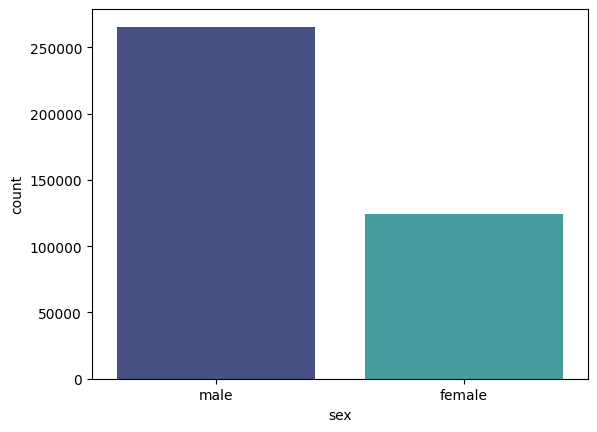

In [ ]:
sns.countplot(x=data.sex, palette='mako')

In [11]:
for i in data.columns:
  data[i].fillna(data[i].mode()[0], inplace=True)

In [ ]:
data.isna().sum()

,0
isic_id,0
target,0
age_approx,0
sex,0
anatom_site_general,0
clin_size_long_diam_mm,0
tbp_lv_A,0
tbp_lv_Aext,0
tbp_lv_B,0
tbp_lv_Bext,0


<Axes: ylabel='age_approx'>

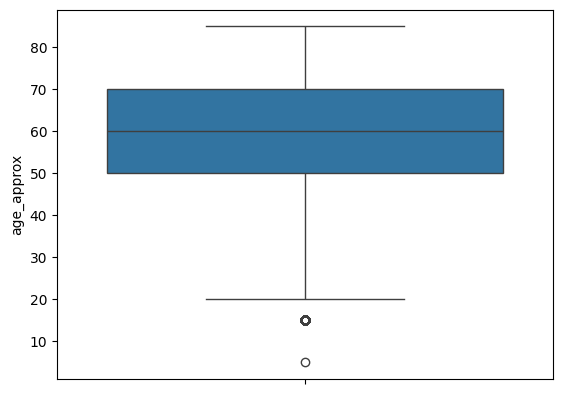

In [ ]:
sns.boxplot(data.age_approx)

In [12]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

<ipython-input-16-3dc3a11bd85c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data.anatom_site_general, palette='mako')


<Axes: xlabel='count', ylabel='anatom_site_general'>

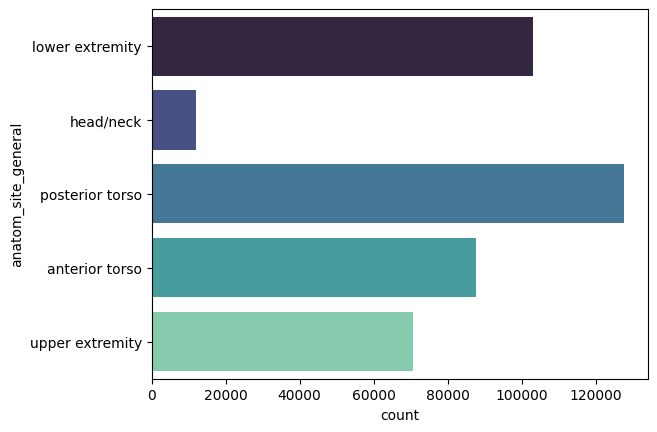

In [ ]:
sns.countplot(data.anatom_site_general, palette='mako')

<ipython-input-21-2742b34e7fe1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data.tbp_lv_location, palette='magma')


<Axes: xlabel='count', ylabel='tbp_lv_location'>

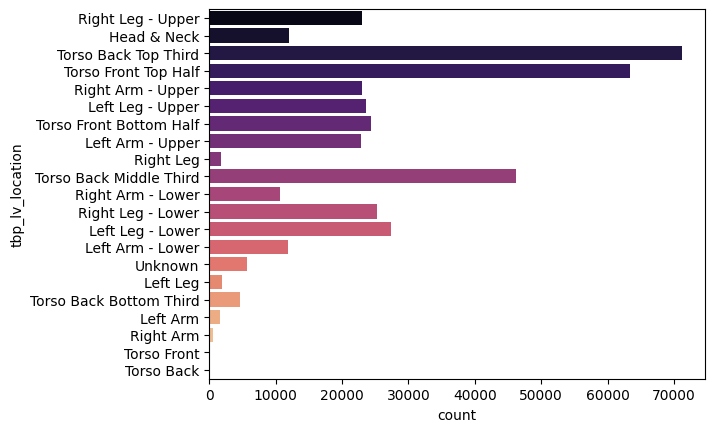

In [ ]:
#data=pd.get_dummies(data, columns=['anatom_site_general'])
sns.countplot(data.tbp_lv_location, palette='magma')

In [ ]:
data.target.value_counts()

,count
target,
0,400666
1,393


In [ ]:
data.dtypes

,0
isic_id,object
target,int64
age_approx,float64
sex,object
anatom_site_general,object
clin_size_long_diam_mm,float64
tbp_lv_A,float64
tbp_lv_Aext,float64
tbp_lv_B,float64
tbp_lv_Bext,float64


In [13]:
le=LabelEncoder()
#var=['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']
for i in data.columns:
        if data[i].dtypes==object:
                if i=='isic_id' or i=='target':
                        continue
                data[i]=le.fit_transform(data[i])

In [14]:
scaler=MinMaxScaler()
for col in data.columns:
    if data[col].dtypes==float or data[col].dtypes=='int64' or data[col].dtypes=='int32':
        if i=='isic_id' or i=='target':
            continue
        data[[col]]=scaler.fit_transform(data[[col]])

In [15]:
data.target=data.target.astype(int)
data.sex=data.sex.astype(int)

In [ ]:
data

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,0.6875,1,0.50,0.074453,0.448560,0.549700,0.502444,0.376069,...,0.000000,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.975173
1,ISIC_0015845,0,0.6875,1,0.25,0.003650,0.674860,0.747149,0.491697,0.391260,...,0.670989,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.031415
2,ISIC_0015864,0,0.6875,1,0.75,0.087591,0.494565,0.568489,0.703178,0.619598,...,0.000000,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.998040
3,ISIC_0015902,0,0.7500,1,0.00,0.081022,0.330121,0.460827,0.402979,0.303669,...,0.000000,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.999900
4,ISIC_0024200,0,0.6250,1,0.00,0.063139,0.536985,0.632028,0.494130,0.420931,...,0.000000,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.704425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,0.8125,1,0.00,0.211679,0.494536,0.521126,0.515904,0.447931,...,0.953575,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,1.000000
401055,ISIC_9999951,0,0.6875,1,0.75,0.077007,0.443295,0.544600,0.633924,0.556393,...,0.000000,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.999998
401056,ISIC_9999960,0,0.7500,0,0.00,0.038321,0.391100,0.465157,0.555550,0.441107,...,0.986127,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,0.999994
401057,ISIC_9999964,0,0.3125,0,0.00,0.065693,0.488897,0.404430,0.529857,0.454194,...,0.000000,0.0,0.0,0.230769,0.583333,0.56,0.0,0.0,0.020833,1.000000


In [17]:
data=data.sort_values(by='target', ascending=False)[:100000]

In [16]:
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
#from tensorflow.keras.utils import to_categorical

# Assuming your CSV has columns including 'id', 'filename' for image file names, 'label' for class labels (0 to 9), and 100 other features
csv_path = data
image_dir = 'train-image/image'

# Load CSV into pandas DataFrame
#df = pd.read_csv(data.csv)

# Load images and labels
# images = []
# labels = []
# features = []
# ids = []

In [ ]:
# #Delete items in folder
# files=['imagefile', 'label', 'feature']
# for i in range(1):
#   with open(f'/content/drive/MyDrive/Colab Notebooks/{files}', 'w') as labels:
#     labels.write(str(''))
#     #labels.close()

In [ ]:
import gc
filenames=[]
labels=[]
images=[]
#import torch
for index, row in data.iterrows():
    try:
        filename = row['isic_id'] + '.jpg'
        label = row['target']
        img_path = os.path.join(image_dir, filename)

        # if filename not in img_path:
        #     del filename
         # Read and preprocess image (resize, normalize, etc.)
        img = imread(img_path)
        img = resize(img, (128, 128))  # Resize to desired size
        img = img.astype('float32') / 255.0  # Normalize pixel values

        # if not os.path.exists(folder_path):
        #     os.makedirs(folder_path)
        #np.savez('D:/Data/Kaggle/dataset.npz', images=img, labels=labels_np)

        images.append(img)
        del img

        labels.append(label)
        del label

        # Extract additional features (assuming they are numeric)
        image_features = row.drop(['isic_id', 'target'])
        filenames.append(image_features)
        del filename

        gc.collect()
        #torch.cuda.empty_cache()
    except FileNotFoundError:
        filename=[]
        label=[]
        features=[]
        #data.drop(data[data.isic_id !=filename], inplace=True)
        # del filename
        # del row
        #data.drop(filename, inplace=True, axis=1)
        continue

In [ ]:
'filenames:', filenames.shape, 'labels:', labels.shape, 'images:',images.shape

In [ ]:
plt.figure(figsize=(10, 4))
for i in images[:10]:
    plt.subplot(1, 3, i + 1)
    img = imread(images[i])
    plt.imshow(img)
    plt.axis('off')
#plt.suptitle(f'Cluster {cluster}')
plt.show()

In [ ]:
labels=np.array(labels)
filenames=np.array(filenames)
images=np.array(images)
#images=images.reshape(images.shape[0], -1)

In [ ]:
np.savez('/content/drive/MyDrive/Colab Notebooks/data.npz', images=images, labels=labels, filenames=filenames)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# Split data into training and validation sets
X_img_train, X_img_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(images, filenames, labels, test_size=0.2, random_state=42)

In [ ]:
input_shape=(128, 128, 3)

In [ ]:
img_input = Input(shape=(128, 128, 3))

model=Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))